# Machine Learing Nano Degree
## Gender Recognition by Voice
## Model Training

In this project, I will try several **suprivised** machine learning algorithm on 3168 samples to predict gender accurately.

First, I will try several models. Then, the best model will be optimized to achieve best performance.

My goal is to construct a model to predict gender accurately.

Dataset comes from [kaggle](https://www.kaggle.com/primaryobjects/voicegender). Features have been extracted by R packages, seewave and tuneR.

---
## Preparation
Load the necessary Python libraries and load preprocessed sets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
%matplotlib inline

In [2]:
with open('train_set.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)

In [3]:
with open('val_set.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

In [4]:
with open('test_set.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

---
## Evaluation of Performance

### Evaluation Standards
This project is aimed to distinguish voice of male and female. The importance equals. So precision and recall rate means nothing. Thus, **accuracy** is evaluation standards.

### Naive Model
If we simply predict every voice is female, we can achieve an accuracy of 50%.

## Surprivised Machine Learning Models
### Candidate Models
- LogisticRegression
- DecisionTree
- RandomForest
- SVM

### Advantages and Disadvantages
Reference:

- http://blog.sciencenet.cn/blog-520608-745856.html
- https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms
- http://idatamining.net/blog/?p=1179

#### Model 1
- Name: LogisticRegression
- Advantages:
    - Fast
    - Simple
    - Giving correlation of features
- Disadvantages:
    - Only good at dataset of linear correlation
    - Needing conversion for more complex correlation
    - Easily under-fitted
    - Poor at large feature space

#### Model 2
- Name: DecisionTree
- Advantages:
    - Able to describe nonlinear correlation
    - Fast
    - Explanatory
    - Compatible with missing features
- Disadvantage:
    - Easily over-fitted

#### Model 3
- Name: RandomForest
- Advantages:
    - Able to process large feature space
    - Compatible with missing features
    - Explanatory
- Disadvantages:
    - Over-fit at dataset with much noise

#### Model 4
- Name: SVM
- Advantages:
    - Generalization
    - Able to process nolinear correlation
- Disadvantages:
    - Sensible to kernel function
    - Slow
    - Little explanatory

### Create Predicting and Evaluating Pipeline

In [5]:
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    Automatically train, predict model and record consuming time.
    : learner: the model to be trained and predicted
    : sample_size: the size of samples to train
    : X_train: features of training set
    : y_train: label of training set
    : X_val: features of validation set
    : y_val: label of validation set
    : return: a dict containing "train_time", "pred_time", "acc_train", "acc_val".
    '''
    
    results = {}
    
    # train and record time
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # get time for training
    results['train_time'] = end - start
    
    # predict validation and train set, and record time
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()
    #predictions_train = [round(value) for value in predictions_train]
    #predictions_val = [round(value) for value in predictions_val]
    
    # get predict time
    results['pred_time'] = end - start
            
    # get training accuracy
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # get validation accuaray
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Evaluate Models

In [6]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# init
clf_A = LogisticRegression()
clf_B = DecisionTreeClassifier(random_state = 157)
clf_C = RandomForestClassifier(random_state = 271)
clf_D = SVC()

# get 1% 10% 100% sample size
samples_1 = int(len(X_train) * 0.01)
samples_10 = int(len(X_train) * 0.1)
samples_100 = len(X_train)

# collect results
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

LogisticRegression trained on 20 samples.
LogisticRegression trained on 202 samples.
LogisticRegression trained on 2027 samples.
DecisionTreeClassifier trained on 20 samples.
DecisionTreeClassifier trained on 202 samples.
DecisionTreeClassifier trained on 2027 samples.
RandomForestClassifier trained on 20 samples.
RandomForestClassifier trained on 202 samples.
RandomForestClassifier trained on 2027 samples.
SVC trained on 20 samples.
SVC trained on 202 samples.
SVC trained on 2027 samples.


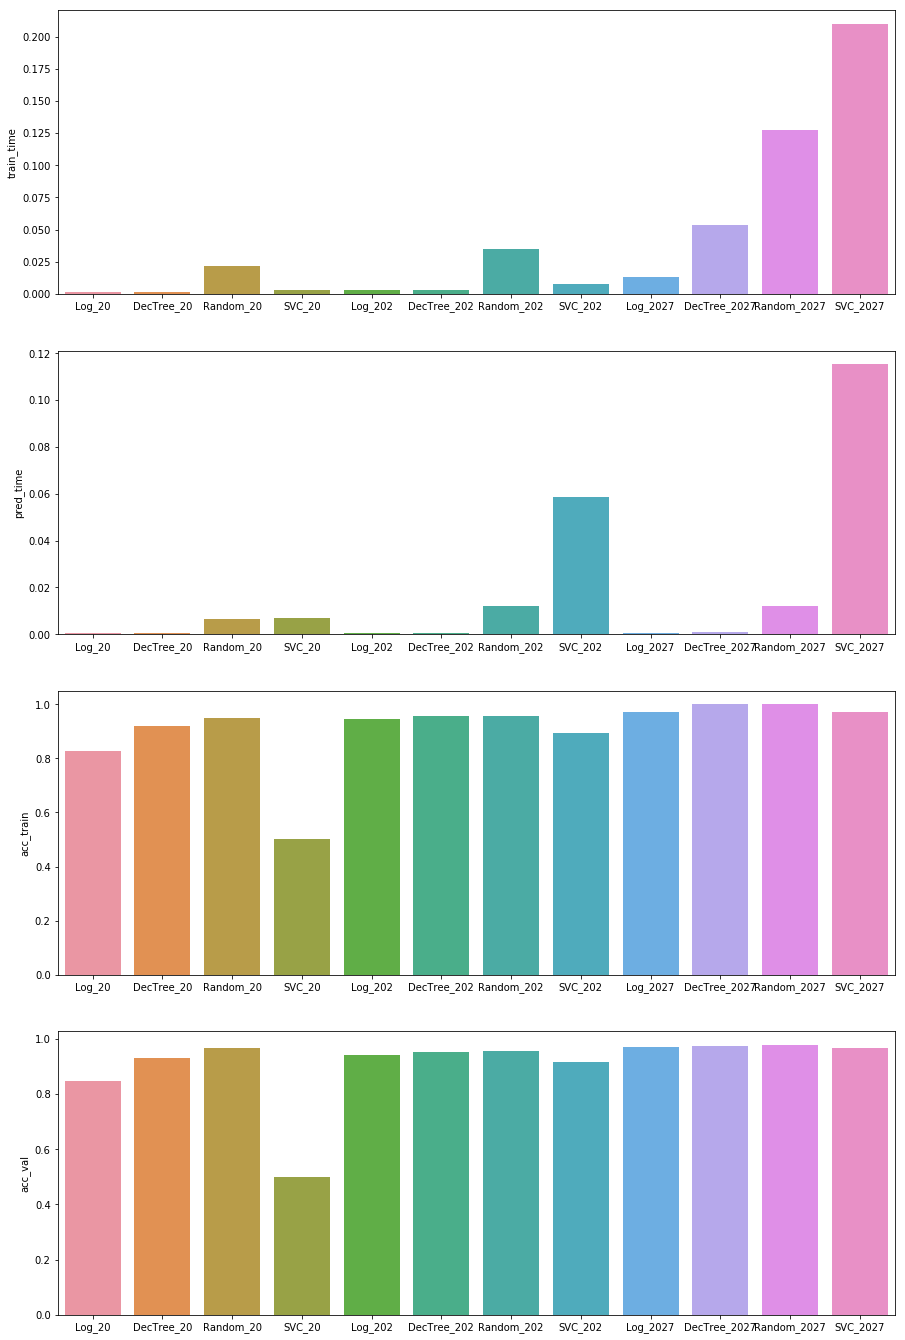

In [7]:
# show results
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 24))
for axi, compare in zip([ax1, ax2, ax3, ax4], ["train_time", "pred_time", "acc_train", "acc_val"]):
    x = ["{}_{}".format(clf_name, samples) 
         for samples in [samples_1, samples_10, samples_100]
         for clf_name in ["Log", "DecTree", "Random", "SVC"]]
    y = [results[clf.__class__.__name__][i][compare] 
         for i in range(3)
         for clf in [clf_A, clf_B, clf_C, clf_D] ]
    sns.barplot(x, y, ax = axi)
    axi.set_ylabel(compare)
        
plt.show()

---
## Optimize Model

### Model Selection
RandomForest has the best validation accuracy at all the time. And it costs little time. Therefore, RandomForest is chosen.

### Optimize

In [8]:
# import model selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

# init model
clf = RandomForestClassifier(random_state=271)

# the parameters to try
parameters = {
                "n_estimators": [10, 50, 100, 200, 400],
                "criterion": ["gini", "entropy"],
                "max_depth": [5, 8, 10, 12]
             }


# use grid search, accuarcy as scoring standard, 5 fold
grid_obj = GridSearchCV(clf, parameters, scoring = "accuracy", cv = 5)

# use train data to get best parameters
grid_obj.fit(X_train, y_train)

# print best parameters
print(grid_obj.best_params_)

# get best estimator
best_clf = grid_obj.best_estimator_

# use unoptimized model to predict for comparasion
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# print results
print("Unoptimized model\n------")
print("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))

{'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 400}
Unoptimized model
------
Accuracy score on validation data: 0.9783

Optimized Model
------
Final accuracy score on the validation data: 0.9822


---
## Feature Importance
Not all the features contribute a lot. In fact, some important features can provide enough information.

For example, the male's voice sounds thick than the female's. So, perhaps we can get pretty good results just using `meanfun`.

### The Top-5 important Features

In [9]:
# train a model
model = RandomForestClassifier(random_state = 125)
model.fit(X_train, y_train)

# get importances
importances = model.feature_importances_

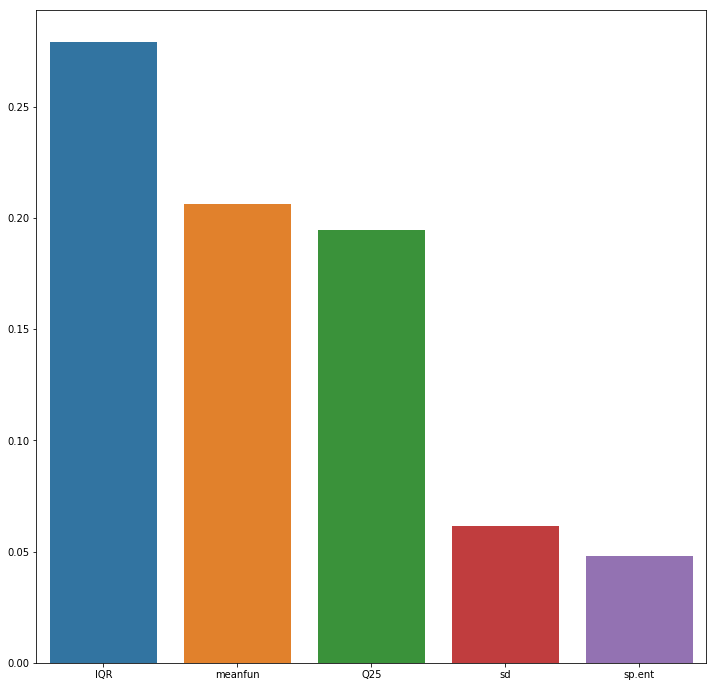

In [10]:
# sort importances
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]

# draw
plt.subplots(figsize = (12, 12))
sns.barplot(columns, values)
plt.show()

The top-5 important features are `IQR`, `meanfun`, `Q25`, `sd`, `sp.ent`. And 3 of them, `IQR`, `meanfun`, `sd` matches observation before.

The sum weights of these 5 features is over 0.7. So I can believe that these 5 features provide most of useful information.

### Reduce Feature Space

Only using the top-5 important feautures can simplift the model, save time for training and predicting. And it is convenient for application since only 5 features of original wave need to be extracted.

In [11]:
from sklearn.base import clone

# reduce feature space
X_train_reduced = X_train[X_train.columns.values[indices[:5]]]
X_val_reduced = X_val[X_val.columns.values[indices[:5]]]

# get a model based on parameters of best estimator
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# predict
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# sum up
print("Final Model trained on full data\n------")
print("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions)))

Final Model trained on full data
------
Accuracy on validation data: 0.9822

Final Model trained on reduced data
------
Accuracy on validation data: 0.9803


https://www.kaggle.com/hadend/tuning-random-forest-parameters
https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

In [12]:
test_predictions = best_clf.predict(X_test)
print("\nFinal Model trained on full data\n------")
print("Final accuracy score on the test data: {:.4f}".format(accuracy_score(y_test, test_predictions)))


Final Model trained on full data
------
Final accuracy score on the test data: 0.9795


In [13]:
X_test_reduced = X_test[X_test.columns.values[indices[:5]]]
test_predictions = clf_on_reduced.predict(X_test_reduced)
print("\nFinal Model trained on reduced data\n------")
print("Final accuracy score on the test data: {:.4f}".format(accuracy_score(y_test, test_predictions)))


Final Model trained on reduced data
------
Final accuracy score on the test data: 0.9763


Only little accuracy was sacrificed after reduction. Considering the reducing amount of calculation and simplification of feature extracting, it is reasonible to use the reduced model for application.

---
## Save Model

In [14]:
with open('model.pkl', 'wb') as fid:
    pickle.dump(clf_on_reduced, fid,2) 

In [15]:
features_min_reduced = features_min[indices[:5]]
features_max_reduced = features_max[indices[:5]]
with open('scale.pkl', 'wb') as fid:
    pickle.dump((features_min_reduced, features_max_reduced), fid,2) 

NameError: name 'features_min' is not defined